In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


DATASET_PATH = "/content/animal_dataset_extracted/animal_dataset"
IMAGE_SIZE = (32, 32)
SPLIT_SIZES = {'train': 240, 'test': 30, 'validation': 30}
RANDOM_SEED = 42

def load_and_preprocess_data(dataset_path, size):
    """Loads images, resizes, converts to grayscale, and flattens them."""
    data = []
    labels = []

    class_names = sorted(os.listdir(dataset_path))

    print("Loading data...")
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                try:

                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    img = cv2.resize(img, size)

                    img_flat = img.flatten()

                    data.append(img_flat)
                    labels.append(i)
                except Exception as e:
                    print(f"Could not load/process image {img_path}: {e}")

    X = np.array(data)
    y = np.array(labels)


    label_map = {i: name for i, name in enumerate(class_names)}

    return X, y, label_map


X_all, y_all, label_map = load_and_preprocess_data(DATASET_PATH, IMAGE_SIZE)
print(f"Total samples loaded: {len(X_all)}")


X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all,
    test_size=SPLIT_SIZES['test'],
    stratify=y_all,
    random_state=RANDOM_SEED
)


val_size_ratio = SPLIT_SIZES['validation'] / (SPLIT_SIZES['train'] + SPLIT_SIZES['validation'])

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_ratio,
    stratify=y_temp,
    random_state=RANDOM_SEED
)


print(f"\n--- Data Split Summary ---")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature shape (per image): {X_train.shape[1]}")
print(f"Number of classes: {len(label_map)} ({label_map})")

Loading data...
Total samples loaded: 300

--- Data Split Summary ---
Training set size: 240 samples
Validation set size: 30 samples
Test set size: 30 samples
Feature shape (per image): 1024
Number of classes: 3 ({0: 'cat', 1: 'dog', 2: 'panda'})


In [ ]:
K_values = range(1, 21, 2)


results_l1 = {'k': [], 'mean_accuracy': []}
results_l2 = {'k': [], 'mean_accuracy': []}

def evaluate_k_nn(X_data, y_data, k_values, metric_name, metric):
    """Performs 5-fold cross-validation for a range of K values."""
    print(f"\nEvaluating K-NN with {metric_name} distance (5-Fold CV)...")

    k_accuracies = []

    for k in k_values:

        model = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)


        scores = cross_val_score(model, X_data, y_data, cv=5, scoring='accuracy')

        mean_acc = scores.mean()
        std_acc = scores.std()
        k_accuracies.append(mean_acc)

        print(f"K={k:2}: Mean CV Accuracy = {mean_acc:.4f} (+/- {std_acc:.4f})")

    return k_values, k_accuracies


k_l1, acc_l1 = evaluate_k_nn(X_train, y_train, K_values, "Manhattan (L1)", "manhattan")
results_l1['k'] = k_l1
results_l1['mean_accuracy'] = acc_l1


k_l2, acc_l2 = evaluate_k_nn(X_train, y_train, K_values, "Euclidean (L2)", "euclidean")
results_l2['k'] = k_l2
results_l2['mean_accuracy'] = acc_l2


best_k_l1 = k_l1[np.argmax(acc_l1)]
best_acc_l1 = np.max(acc_l1)

best_k_l2 = k_l2[np.argmax(acc_l2)]
best_acc_l2 = np.max(acc_l2)

print("\n--- Optimal K Values (from Training Set CV) ---")
print(f"Manhattan (L1): Best K = {best_k_l1}, CV Accuracy = {best_acc_l1:.4f}")
print(f"Euclidean (L2): Best K = {best_k_l2}, CV Accuracy = {best_acc_l2:.4f}")


if best_acc_l1 >= best_acc_l2:
    BEST_K = best_k_l1
    BEST_METRIC = 'manhattan'
    print(f"\nChoosing Manhattan (L1) with K={BEST_K} for final model.")
else:
    BEST_K = best_k_l2
    BEST_METRIC = 'euclidean'
    print(f"\nChoosing Euclidean (L2) with K={BEST_K} for final model.")

final_model = KNeighborsClassifier(n_neighbors=BEST_K, metric=BEST_METRIC, n_jobs=-1)
final_model.fit(X_train, y_train)


y_pred_test = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"--- Final Model Evaluation on TEST Set ({BEST_METRIC}, K={BEST_K}) ---")
print(f"Test Set Accuracy: {test_accuracy:.4f}")


Evaluating K-NN with Manhattan (L1) distance (5-Fold CV)...
K= 1: Mean CV Accuracy = 0.3583 (+/- 0.0580)
K= 3: Mean CV Accuracy = 0.3708 (+/- 0.0445)
K= 5: Mean CV Accuracy = 0.3500 (+/- 0.0482)
K= 7: Mean CV Accuracy = 0.3583 (+/- 0.0534)
K= 9: Mean CV Accuracy = 0.3958 (+/- 0.0417)
K=11: Mean CV Accuracy = 0.4000 (+/- 0.0482)
K=13: Mean CV Accuracy = 0.4333 (+/- 0.0610)
K=15: Mean CV Accuracy = 0.4125 (+/- 0.0664)
K=17: Mean CV Accuracy = 0.3958 (+/- 0.0632)
K=19: Mean CV Accuracy = 0.4292 (+/- 0.0654)

Evaluating K-NN with Euclidean (L2) distance (5-Fold CV)...
K= 1: Mean CV Accuracy = 0.3208 (+/- 0.0705)
K= 3: Mean CV Accuracy = 0.3333 (+/- 0.0264)
K= 5: Mean CV Accuracy = 0.3625 (+/- 0.0429)
K= 7: Mean CV Accuracy = 0.3792 (+/- 0.0306)
K= 9: Mean CV Accuracy = 0.3500 (+/- 0.0358)
K=11: Mean CV Accuracy = 0.3583 (+/- 0.0404)
K=13: Mean CV Accuracy = 0.3625 (+/- 0.0408)
K=15: Mean CV Accuracy = 0.3792 (+/- 0.0550)
K=17: Mean CV Accuracy = 0.3667 (+/- 0.0283)
K=19: Mean CV Accuracy 

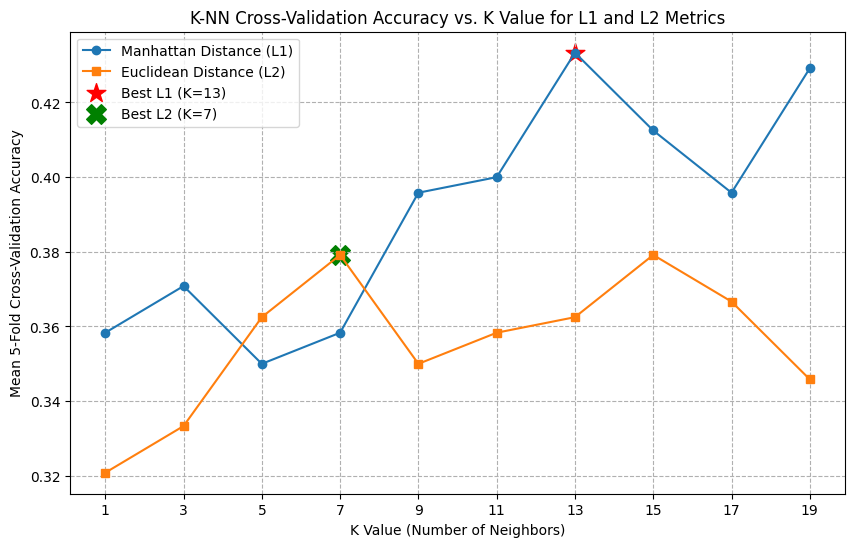


--- Top 5 Predictions on the Test Set ---


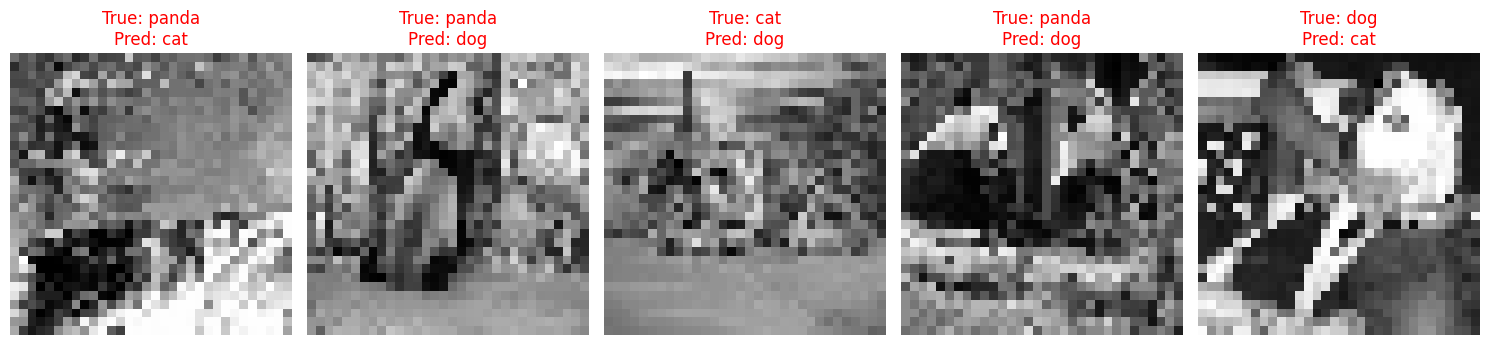

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results_l1['k'], results_l1['mean_accuracy'], marker='o', label='Manhattan Distance (L1)')
plt.plot(results_l2['k'], results_l2['mean_accuracy'], marker='s', label='Euclidean Distance (L2)')


plt.scatter(best_k_l1, best_acc_l1, color='red', marker='*', s=200, label=f'Best L1 (K={best_k_l1})')
plt.scatter(best_k_l2, best_acc_l2, color='green', marker='X', s=200, label=f'Best L2 (K={best_k_l2})')

plt.title('K-NN Cross-Validation Accuracy vs. K Value for L1 and L2 Metrics')
plt.xlabel('K Value (Number of Neighbors)')
plt.ylabel('Mean 5-Fold Cross-Validation Accuracy')
plt.xticks(results_l1['k'])
plt.legend()
plt.grid(True, linestyle='--')
plt.show()



print("\n--- Top 5 Predictions on the Test Set ---")


indices_to_show = np.random.choice(len(X_test), 5, replace=False)

plt.figure(figsize=(15, 6))
for i, index in enumerate(indices_to_show):

    image_data = X_test[index]
    true_label_idx = y_test[index]
    predicted_label_idx = y_pred_test[index]

    true_label_name = label_map[true_label_idx]
    predicted_label_name = label_map[predicted_label_idx]


    image_display = image_data.reshape(IMAGE_SIZE)

    plt.subplot(1, 5, i + 1)
    plt.imshow(image_display, cmap='gray')

    title_color = 'green' if true_label_idx == predicted_label_idx else 'red'
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In this assignment, we focus on classifying images into three categories using the k-Nearest Neighbors (k-NN) algorithm. The primary goal is to compare two fundamental distance measurement techniques: Manhattan ($L1$) and Euclidean ($L2$). Using a dataset of 300 grayscale images ($32 \times 32$ pixels), we apply 5-fold cross-validation to rigorously test the model. By plotting the accuracy against various values of $K$, we aim to identify the most suitable distance metric and hyperparameter configuration for this dataset, concluding with a showcase of the model's top predictions.